# Outline

This notebook complements the blog post and is intended to cover the following:
- [Reproducing results](#reproducing-results)
- [Deep dive and error analysis](#deep-dive-and-error-analysis)
- [Score and analyze your own data](#score-and-analyze-your-own-data)
- [Conclusion](#conclusion)
- [Appendix](#appendix)


# Reproducing results<a id='reproducing-results'></a>

## Setup


If you have cloned the repro and are running this locally, make sure you first follow setup in `tdrz_dev/README.md`. This notebook handles the rest of the setup (including downloading eval data).

> *NOTE: If running on Google Colab - until we figure out how to get the fstalign scoring tool working there - this notebook will fetch pre-computed scored results. You can still run the error inspection and analysis sections.*

In [1]:
import matplotlib.pyplot as plt
from IPython import get_ipython
from IPython import display as ipd

In [2]:
if 'google.colab' in str(get_ipython()):
    # clone a particular branch of tinydiarize repo
    ! git clone https://github.com/akashmjn/tinydiarize.git -b analysis-1 --single-branch
    # pip install
    ! pip install -e tinydiarize
    # setup workdir
    WORKDIR = 'tinydiarize/tdrz_dev/workdir_analysis'
    CODEDIR = 'tinydiarize/tdrz_dev'
    _PRE_COMPUTED = True
else:
    # if running locally, assume that tinydiarize repo is already cloned and setup
    WORKDIR = '../workdir_analysis'
    CODEDIR = '..'
    _PRE_COMPUTED = False

# _PRE_COMPUTED = True  # comment out if you want to just quickly step through analysis

ipd.clear_output()

## Evaluation data

We adopt the zero-shot evaluation scheme of Whisper, testing out of the distribution that the tinydiarize model was finetuned on (`AMI meetings`). This allows us to get a more realistic estimate of real-world generalization vs the model's ability to fit `AMI meetings` dataset-specific quirks.

For ease of analysis (and keeping with the 'tiny' spirit 😉) I've chosen a biased subset of 3 earnings calls from [rev/earnings21](https://github.com/revdotcom/speech-datasets/blob/main/earnings21/earnings21-file-metadata.csv). These were selected with the following criteria:
- One interactive Q&A meeting (*939, Hershey) with a higher number of speaker switches and unique speakers
- One meeting (*910, Amex) that is a moderated Q&A between only 2 speakers
- One meeting (*971, Constellium) that comprises both a presentation and Q&A session, and is somewhere in between

| file_id | audio_length | company_name | sector | speaker_switches | speaker_switches / minute | unique_speakers |
|---------|--------------|--------------|--------|------------------|---------------------------|-----------------|
| 4385939 | 3049.832     | Hershey Company | Consumer Goods | 132 | 2.60 | 19 |
| 4374910 | 2028.536     | American Express Company | Financial | 56 | 1.66 | 2 |
| 4359971 | 3759.944     | Constellium | Industrial Goods | 116 | 1.85 | 10 |

In [4]:
# setup workdir structure and fetch evaluation data
if _PRE_COMPUTED:
    # download pre-computed results from blob
    ! wget -O {CODEDIR}/workdir_analysis.tar.gz https://sharedstorage7190.blob.core.windows.net/tinydiarize/precomputed/workdir_analysis-051923/01ee4ffffa9cf852868cdfbb4c12d091b332940f6eaf798e0e5e0ffd672378d5.tar.gz
    # compute the SHA256 hash of the downloaded file
    ! echo "SHA256 hash of downloaded file: $(sha256sum {CODEDIR}/workdir_analysis.tar.gz)"
    # unpack pre-computed results into WORKDIR
    ! tar -xzf {CODEDIR}/workdir_analysis.tar.gz -C {CODEDIR}
else:
    ! mkdir -p {WORKDIR}
    # call a bash script with WORKDIR as an environment variable
    ! bash {CODEDIR}/scripts/fetch_earnings21_calls.sh {WORKDIR}

ipd.clear_output()

In [ ]:
# listen to an example file 
ipd.Audio(f'{WORKDIR}/audio/earnings21-4374910.mp3')

## Transcribing and scoring

We use the `run_pipelines.py` convenience script to transcribe and score the calls. It runs ASR (Whisper `small.en`) along with various diarization pipelines (explained in the following sections), scores them and parses detailed results into a single tsv file. Make sure you have completed the setup steps above and have an appropriate token file.

> *NOTE: On Google colab, we skip this step and use pre-computed results from my runs, as it's currently tricky to setup the fstalign scoring tool*

In [ ]:
if not _PRE_COMPUTED:
    # change directory to ../scripts
    %cd {CODEDIR}/scripts

    # process all the selected calls
    calls = [
        ("earnings21-4385939", 19),
        ("earnings21-4374910", 2),
        ("earnings21-4359971", 10),
    ]

    # iterate over calls and run the script run_pipelines.py
    for call_id, num_speakers in calls:
        # provide the oracle # speakers to pipelines that do clustering as we only evaluate local diarization i.e. segmentation
        ! python run_pipelines.py {WORKDIR}/audio/{call_id}.mp3 {WORKDIR}/fstalign_scoring/references/{call_id}-ref.nlp {WORKDIR}/transcripts --num_speakers {num_speakers} --hf_token_file "HF_TOK.txt"

    # change directory back to ../notebooks
    %cd {CODEDIR}/notebooks


# Deep dive and error analysis<a id='deep-dive-and-error-analysis'></a>

## Information on metrics

Diarization typically uses either time-based metrics (e.g. DER measures % of time correctly attributed) or transcript-based metrics that compare the final transcript. 

I prefer to use transcript-based metrics as:
- It helps us see errors the way an end-user would i.e. [WYSIWYG](https://en.wikipedia.org/wiki/WYSIWYG).
- Analyzing errors in the semantic context of the conversation is much more intuitive, and helps us quickly get a sense of where we really need to focus.
- Tricky edge cases such as disfluencies, speaker overlap, etc. can be handled in an interpretable way via the transcription convention (e.g. using special tokens and/or text normalization).

In this notebook we focus on "local" diarization i.e. speaker segmentation (and not the "global" task of clustering speakers across the entire meeting). We use the following metrics for ease of interpretation and analysis:
- WER: word error rate as measured by `fstalign`
- Speaker turn recall: fraction of speaker changes that are correctly identified
- Speaker turn precision: fraction of predicted speaker changes that are correct

Just like WER, speaker turn recall and precision are computed by aligning reference and hypothesis transcripts after inserting a special `speaker__turn` token, and then counting errors on the special tokens. We also parse the aligned ref/hyp transcripts for error analysis. *(see implementation in `score.py` for details)*

## Comparing results

In [5]:
# some utility functions
%load_ext autoreload
%autoreload 2
import sys; sys.path.append(CODEDIR)
from analysis_utils import compile_results, summarize_results, query_metric_results, plot_metric_results, inspect_errors

We compile all the TSV files generated by `run_pipelines.py` into a single dataframe for analysis. The dataframe contains both WER and speaker turn metrics along with a detailed error breakdown e.g. (DEL/INS/SUB) for WER, false negatives (DEL/SUB) for speaker turn recall, and false positives (INS/SUB) for speaker turn precision. 

We also parse a useful `*.sbs` file output by fstalign containing ref/hyp aligned with the errors. This is very helpful for error inspection and debugging.

In [6]:
results_all_df, analysis_results = compile_results(f"{WORKDIR}/fstalign_scoring/results")

Read 84 results from 21 files
Read 21 side-by-side analysis results


We compare the following approaches:
- `punctuation`: Simple baseline adding a speaker turn after every ending punctuation e.g. `.?!`. The recall of this baseline helps us get a sense for how well Whisper is already implicitly marking speaker turns (i.e. does it miss any). We hypothesize that the semantic context of a conversation is a strong signal for both punctuations and speaker turns.

- `pyannote_pre_sr`: Runs full pyannote diarization pipeline, and then whisper.transcribe on segments created by the pipeline, retaining the speaker assignment for each segment. [Pyannote](https://huggingface.co/pyannote/speaker-diarization) is a strong open-source baseline that runs dedicated 2-stage diarization models (segmentation + clustering).

- `segment_timestamped`: Simple baseline that adds a speaker turn after every segment marked between timestamps (e.g. 00:27.080 --> 00:32.720 "this is a segment"). Similar to `punctuation`, the recall of this simple baseline helps us get a rough upper bound for how well timestamp-based [heuristic clustering approaches](https://huggingface.co/spaces/vumichien/Whisper_speaker_diarization) can do.

- `tdrz_token`: tinydiarize model introducing a new `speaker_turn` token in the vocabulary which is decoded in whisper.transcribe itself. It was finetuned on ~100hrs from the AMI meetings dataset prepared into long-form 30s chunks. Viewing this as a special case of punctuations, we'd expect this to have a much better precision than the `punctuation` baseline, with its recall as an upper bound. 

We are not aiming to outperform the state of the art, but to explore how well Whisper can infer speaker turns with its implicit prior via the finetuned `tdrz_token` prototype. We also want to see if we can keep the original WER performance without overfitting to the finetuning dataset. If it works, this approach has the advantage of simpler and faster inference that can be easily integrated into optimized pipelines like [whisper.cpp](https://github.com/ggerganov/whisper.cpp).

Total # of words: 23630, Total # of speaker turns: 301


model                 small.en                                      \
method             punctuation pyannote_pre_sr segment_timestamped   
metric                                                               
spk_turn_precision       19.49           83.39               14.52   
spk_turn_recall          92.03           78.41               86.71   
wer_overall              10.95           12.94               10.95   
wer_speaker_switch       14.96           23.13               14.96   

model              small.en-tdrz  
method                tdrz_token  
metric                            
spk_turn_precision         98.16  
spk_turn_recall            70.76  
wer_overall                10.30  
wer_speaker_switch         15.56

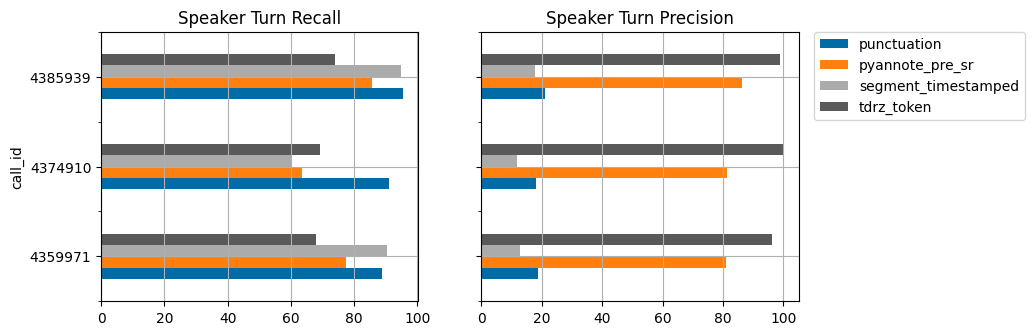

In [7]:
summary_df, results_df = summarize_results(results_all_df)
ipd.display(summary_df)

# plotting per-meeting speaker turn results
fig, axes = plt.subplots(1, 2, figsize=(9, 3.5), sharey=True)
d1 = query_metric_results(results_df, "spk_turn_recall", groups=["call_id", "method"])
plot_metric_results(d1, title="Speaker Turn Recall", ax=axes[0], legend=False)
d2 = query_metric_results(results_df, "spk_turn_precision", groups=["call_id", "method"])
plot_metric_results(d2, title="Speaker Turn Precision", ax=axes[1])

We can make the following observations:
1. The recall of the simple `punctuation` baseline is quite high i.e. it rarely misses punctuating a speaker turn. This validates our hypothesis that the model already has a good implicit representation of speaker turns via both acoustic and semantic cues (much like a punctuation).
2. The `pyannote_pre_sr` pipeline has good all-round performance, although it actually has a bit lower recall than the simple `punctuation` baseline. As we'll see in the next section this is primarily due to handling of short segments.
3. The `segment_timestamped` baseline is somewhat erratic, either matching `punctuation` or with a big gap on call `*910`. The consistency of whisper timestamps is known to be a bit erratic, so this is not surprising.
4. The `tdrz_token` approach significantly improves precision over the punctuation baseline to almost 100%, while incurring some loss of recall. Strong performance with a very simple finetuning setup shows that we can cheaply isolate behavior that was already present in Whisper models.

In the next section, by manually inspecting errors we can build some intuition for the strengths and weaknesses of different approaches.

## Error inspection

We now look through some examples to understand where the bottlenecks lie. Our choice of transcript-based metrics (speaker turn precision/recall) allows us to do this in a very interpretable way, by simply reading the aligned transcripts around speaker turn errors.

We will see that:
- Short segments (e.g. 1-2s backchannel) are a major source of errors for `pyannote_pre_sr`. Approaches of this kind have to trade-off temporal resolution vs quality of representations, often at extra cost and complexity, as they operate independently of ASR relying on only acoustic information.
- Semantic information available to Whisper simplifies this problem significantly. Being trained to output punctuations imparts a strong prior which nearly eliminates such types of errors.
- The near 100% precision of `tdrz_token` approach confirms the value of this prior, although there remains a lot of room for improvement in recall. There is no significant trend in the errors, so it's possible that the current prototype is under-trained and could benefit from more data.


In [ ]:
# listen to an example file
call_id = "4385939"
ipd.Audio(f'{WORKDIR}/audio/earnings21-{call_id}.mp3')

### Recall errors: Short segments and importance of semantic context

We step through individual `recall_errors` below and have categorized them into the following types:

|Error type|pyannote_pre_sr|punctuation|tdrz_token|
|:----|:----|:----|:----|
|Recall|85%|95%|74%|
|# false negatives (out of 131)|19|6|34|
|invalid|2|2|4|
|ASR deletion|6|4|12|
|short segment|11|0|10|
|other segment|0|0|8|

#### pyannote_pre_sr:

Due to the way we run `pyannote_pre_sr`, recall errors are slightly inflated due to extra ASR deletions (6 vs 4) caused by Whisper skipping over words when transcribing chopped-up segments from the output of pyannote. See discussion in the next section for more details.

Regardless - looking at the remaining errors, all of them (11) are clearly around few-word short segments that are merged into surrounding ones. As discussed in the blog post, this is a known design limitation of acoustic-embedding based diarization that creates a tradeoff between temporal resolution and accuracy. 

On reading through these errors ourselves, we can actually easily identify many of the speaker turns just from the semantic context even without listening to the audio.


In [9]:
# notes on errors:
# 0,7,8,10,11,13  - ASR deletion
# 1,2,3,6*,9,12,14,15,16,17,18  - short segment
# 4,5 - invalid (nonverbal speech)
inspect_errors(results_df, analysis_results, ("small.en", call_id, "pyannote_pre_sr"), recall_errors=[6])

Results for: ('small.en', '4385939', 'pyannote_pre_sr')


,metric,value,denominator,numerator,deletions,insertions,substitutions
0,wer_overall,11.274131,9065,1022,625,131,266
1,wer_speaker_switch,18.937875,998,189,70,68,51
2,spk_turn_precision,86.153847,130,112,0,16,2
3,spk_turn_recall,85.496178,131,112,17,0,2


Precision errors: 18
Recall errors: 19

 ---------- Recall errors: ----------

Line: 3263, Index: 6
                okay	okay                			
              thanks	thanks              			
                  so	so                  			
                much	much                			
                 for	for                 			
                 the	the                 			
               color	color               			
               there	there               			
       speaker__turn	speaker__turn       			
          absolutely	absolutely          			
       speaker__turn	<del>               	ERR	___41_SPEAKER_TURN___	41|
               thank	thank               			
                 you	you                 			
                 our	our                 			
                next	next                			
            question	question            			
               comes	comes               			
                from	from                			
               <ins>	the                 	ERR		
               

#### punctuation:

Due to availability of semantic context to Whisper's decoder, we see none of the short segment recall errors above i.e. Whisper almost always places punctuations to demarcate different speakers. The only remaining errors are ASR deletions (similar to those seen above) as Whisper doesn't always recognize partially overlapped words.

In [10]:
# notes on recall errors:
# 0,5 - invalid (nonverbal speech)
# 1,2,3*,4 - ASR deletion
inspect_errors(results_df, analysis_results, ("small.en", call_id, "punctuation"), recall_errors=[3])

Results for: ('small.en', '4385939', 'punctuation')


,metric,value,denominator,numerator,deletions,insertions,substitutions
0,wer_overall,10.298820,9069,934,622,84,228
1,wer_speaker_switch,11.523046,998,115,68,11,36
2,spk_turn_precision,20.903011,598,125,0,336,137
3,spk_turn_recall,95.419846,131,125,5,0,1


Precision errors: 473
Recall errors: 6

 ---------- Recall errors: ----------

Line: 6714, Index: 3
                  we	we                  			
                sell	sell                			
                  in	in                  			
              bricks	bricks              			
                 and	and                 			
              mortar	mortar              			
              steve-	<del>               	ERR		
       speaker__turn	speaker__turn       			
               right	<del>               	ERR		
               right	<del>               	ERR		
       speaker__turn	steve               	ERR	___84_SPEAKER_TURN___	84|
            anything	anything            			
                 you	you                 			
               <ins>	want                	ERR		
               wanna	to                  	ERR		
                 add	add                 			
       speaker__turn	speaker__turn       			
                yeah	yeah                			
                   i	i                   			
   

#### tdrz_token:

The finetuned `tdrz_token` model has higher recall errors in all categories, indicating some kind of under-prediction bias. Given the simple finetuning setup, this is not too bad and we should be able to improve it with more data.
One concerning trend is a 3x higher rate of ASR deletions (12 vs 4), which may warrant taking a closer look at the finetuning data labels.

In [11]:
# notes on recall errors:
# 0,1,23*,24,28,29,32*,33 - other segment 
# 5,15,16,17,18,19,22,27,30,31 - short segment
# 2,3,4,8,9,10,11,12,13,14,20,21 - ASR deletion
# 6,7,25,26 - invalid (nonverbal speech)
inspect_errors(results_df, analysis_results, ("small.en-tdrz", call_id, "tdrz_token"), recall_errors=[32])

Results for: ('small.en-tdrz', '4385939', 'tdrz_token')


,metric,value,denominator,numerator,deletions,insertions,substitutions
0,wer_overall,7.543008,9068,684,85,232,367
1,wer_speaker_switch,11.923847,998,119,31,32,56
2,spk_turn_precision,98.979591,98,97,0,1,0
3,spk_turn_recall,74.045799,131,97,29,0,5


Precision errors: 1
Recall errors: 34

 ---------- Recall errors: ----------

Line: 9385, Index: 32
                 the	the                 			
               floor	floor               			
                back	back                			
                  to	to                  			
                  ms	ms                  			
               poole	poole               			
                 for	for                 			
                 any	any                 			
               final	final               			
            comments	comments            			
       speaker__turn	<del>               	ERR	___129_SPEAKER_TURN___	129|
               thank	thank               			
                 you	you                 			
                 all	all                 			
                 for	for                 			
             joining	joining             			
                  us	us                  			
                this	this                			
             morning	morning             			
                

### Precision errors

Most of precision errors for `pyannote_pre_sr` are due to over-segmentation, where its segmentation model appears to create short extra segments that are either duplicated or overlapped with the main content. This is also related to the time-resolution vs accuracy trade-off discussed above, that is exacerbated in areas of quick speaker turns. In some cases these overlapped extra segments end up getting serialized out of order as well, which is a separate issue. ([discussed later](#combining-pyannote-and-transcription-pipelines))

> For the serialization errors here, it is especially helpful to correlate with the original transcripts that contain timestamps. These can be found under `WORKDIR/transcripts/small.en/CALLID_drz_pre_sr/*.vtt`. 

Meanwhile, the `tdrz_token` model has near 100% precision, showing that the extra `speaker_turn` token has quickly learned to be a strong indicator of speaker turns. This is a very promising result, as it shows that we can cheaply isolate behavior that was already present in Whisper models.

|Error type|pyannote_pre_sr|tdrz_token|
|:----|:----|:----|
|Precision|86%|99%|
|# predictions|130|96|
|# false positives|18|1|
|duplicate segment|3|0|
|extra segment|5|1|
|duplicate + serialization error|3|0|
|extra + serialization error|5|0|


In [14]:
# notes on precision errors:
# 0,8,11* - duplicate segment
# 1,2,4,5,6,17 - extra segment
# 3,7,12 - duplicate + serialisation
# 9,10,13,14,15,16 - extra segment + serialisation 
inspect_errors(results_df, analysis_results, ("small.en", call_id, "pyannote_pre_sr"), precision_errors=[11])

Results for: ('small.en', '4385939', 'pyannote_pre_sr')


,metric,value,denominator,numerator,deletions,insertions,substitutions
0,wer_overall,11.274131,9065,1022,625,131,266
1,wer_speaker_switch,18.937875,998,189,70,68,51
2,spk_turn_precision,86.153847,130,112,0,16,2
3,spk_turn_recall,85.496178,131,112,17,0,2


Precision errors: 18
Recall errors: 19

 ---------- Precision errors: ----------

Line: 4772, Index: 11
                  an	an                  			
                even	even                			
             greater	greater             			
              amount	amount              			
                  of	of                  			
             pricing	pricing             			
               power	power               			
       speaker__turn	speaker__turn       			
              really	really              			
             helpful	helpful             			
               <ins>	speaker__turn       	ERR		
               <ins>	really              	ERR		
               <ins>	helpful             	ERR		
               thank	thank               			
                 you	you                 			
                  so	so                  			
                much	much                			
       speaker__turn	speaker__turn       			
               thank	thank               			
                 you	you        

In [15]:
# 0 - short extra segment
inspect_errors(results_df, analysis_results, ("small.en-tdrz", call_id, "tdrz_token"))

Results for: ('small.en-tdrz', '4385939', 'tdrz_token')


,metric,value,denominator,numerator,deletions,insertions,substitutions
0,wer_overall,7.543008,9068,684,85,232,367
1,wer_speaker_switch,11.923847,998,119,31,32,56
2,spk_turn_precision,98.979591,98,97,0,1,0
3,spk_turn_recall,74.045799,131,97,29,0,5


Precision errors: 1
Recall errors: 34


# Score and analyze your own data<a id="score-and-analyze-your-own-data"></a>

To do so, you will need to:
- Replace files under `WORKDIR/audio` with your own audio files
- Create reference files in the [fstalign NLP format](https://github.com/revdotcom/fstalign/blob/develop/docs/NLP-Format.md]) under `WORKDIR/fstalign_scoring/references` 
- Make sure that the NLP contains speaker IDs in column 2. These are only used to score speaker turns. If your transcript only has speaker turns without global IDs, you can just increment a dummy speaker ID after every turn.

Once this is done, you can simply plug it in to the `run_pipelines.py` script as above.

# Conclusion<a id="conclusion"></a>

In conclusion, we have shown that:
- Whisper models already have a good implicit representation of speaker turns via both acoustic and semantic cues (much like a punctuation).
- The `tdrz_token` prototype shows that we can cheaply isolate this behavior with a simple finetuning setup, without too much impact on word error rate.
- Conventional acoustic-embedding diarization approaches like `pyannote_pre_sr` have trouble with short segments & quick speaker turns due to design limitations, and can benefit from semantic context.
- With improvments to the finetuning setup, we can expect to see strong performance from `tdrz_token` which can leverage the best of both worlds.

In [16]:
ipd.display(summary_df)

model                 small.en                                      \
method             punctuation pyannote_pre_sr segment_timestamped   
metric                                                               
spk_turn_precision       19.49           83.39               14.52   
spk_turn_recall          92.03           78.41               86.71   
wer_overall              10.95           12.94               10.95   
wer_speaker_switch       14.96           23.13               14.96   

model              small.en-tdrz  
method                tdrz_token  
metric                            
spk_turn_precision         98.16  
spk_turn_recall            70.76  
wer_overall                10.30  
wer_speaker_switch         15.56

# Appendix<a id="appendix"></a>

In this section we go over some miscellaneous notes and observations that didn't fit in the main sections.

### Runtime comparison

These numbers were tested using the earnings21-4374910 call (33.8 min) on a Quadro RTX 5000 GPU. Whisper is run with beam_size=4 and condition_on_previous_text=True.

- The pyannote diarization pipeline takes an extra ~47% of transcription time. This includes 2 steps: local speaker segmentation + global clustering.
- To get an idea of the time taken for the global clustering step, I tested a naive clustering of Whisper produced segments (see `drz_post_sr` in `run_pipelines.py`). This is quite fast, taking only 3% of transcription time, implying that the segmentation step is likely the main bottleneck in pyannote.
- Lastly, we see that speaker segmentation done by `tdrz_token` is much cheaper, taking 8% extra transcription time. The extra time is a mix of the marginal cost of decoding extra `speaker_turn` tokens, and a couple of more hallucinations from the finetuned model.

|Stage|Runtime (s)|Extra cost (%)|
|:----|:----|:----|
|Whisper.transcribe|121.2|-|
|Pyannote diarization|56.6|47%|
|Clustering whisper segments|3.4|3%|
|Whisper.transcribe (tdrz)|131.5|8%|

### Impact of fine-tuning

While the overall numbers are similar - taking a closer look, we do see some differences in both recognition (especially deletions) and timestamp behavior of the finetuned model. This is likely related to properties of the finetuning data, and could be probably be mitigated further with parameter-efficient finetuning methods that will be better regularizers.

In [17]:
cols = ["call_id", "model", "value", "deletions", "insertions", "substitutions"]
results_all_df.query("metric=='wer_overall' and method=='punctuation'")[cols].sort_values(["call_id", "model"])

,call_id,model,value,deletions,insertions,substitutions
0,4359971,small.en,12.074689,663,130,371
0,4359971,small.en-tdrz,14.672616,151,589,674
0,4374910,small.en,9.937005,322,41,126
0,4374910,small.en-tdrz,6.825107,53,99,184
0,4385939,small.en,10.298820,622,84,228
0,4385939,small.en-tdrz,7.543008,85,232,367


In [18]:
cols = ["call_id", "model", "value", "deletions", "insertions", "substitutions"]
results_all_df.query("metric=='spk_turn_recall' and method=='segment_timestamped'")[cols].sort_values(["call_id", "model"])

,call_id,model,value,deletions,insertions,substitutions
3,4359971,small.en,90.434784,10,0,1
3,4359971,small.en-tdrz,75.652176,21,0,7
3,4374910,small.en,60.000004,19,0,3
3,4374910,small.en-tdrz,70.909088,15,0,1
3,4385939,small.en,94.656494,6,0,1
3,4385939,small.en-tdrz,80.152672,21,0,5


### Combining pyannote and transcription pipelines

For our analysis we chose to transcribe segments output by pyannote after serializing them into a single order. This removes any ambiguity in speaker assignment, however can have a few edge cases due to duplicate overlapped segments created by Pyannote that are serialized out of order as seen with "in your mind" below. This particularly impacts WER around speaker switches (15% -> 23% as seen above).

![screenshot of transcript](duplicate-serialization.png)]

Both ASR and diarization could also be run totally indepedently. This way the original WER is not affected. But it requires combining the two with careful heuristic matching of timestamps to handle various overlap/extra/duplicate segment edge cases. The best example of this is [WhisperX](https://github.com/m-bain/whisperX) which currently adds a 3rd model to get word-level timestamps to help matching. I went with a simple approach for ease of illustration, although it should be possible to compare the two approaches as well.

*(as a sidenote, since reconciling duplicate/partially overlapped speech requires semantic information, I personally think it is cleanest and best done within the transcription pipeline itself as it has access to both acoustic and semantic information)*

### Extending with global clustering

Future work will explore extending segments produced by `tdrz_token` with global clustering. Here are some rough thoughts:
- As we saw above, creating embeddings + clustering a given set of segments is much faster than the segmentation step itself, so it will remain relatively "tiny" and efficient 😊.
- Since we're getting near-perfect precision from predicted speaker turns, they can actually be used as constraints during clustering as done in [Turn-to-Diarize](https://arxiv.org/abs/2109.11641).
- An early implementation of AHC-based clustering is in `drz_post_sr` in `run_pipelines.py`, although we'll likely want to use [NMESC](https://github.com/tango4j/Auto-Tuning-Spectral-Clustering). Contributions are welcome!